In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("thesis")
from os.path import join
import seaborn as sns
from sys import path
path.insert(0,'../src/')
from glob import glob
from chemulator import Chemulator
import matplotlib.gridspec as gridspec
from time import perf_counter
import h5py
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
from snapshot_functions import get_elemental_abundances


In [2]:
#constants
XH  = 0.76                        # the hydrogen mass fraction
gama= 5.0/3.0                     # the adiabatic index
KB  = 1.3807e-16                  # the Boltzmann constant in CGS units  [cm^2 g s^-2 K^-1]
KB_kev  = 8.6173324e-8 
mp  = 1.6726e-24                  # proton mass in CGS units
UnitMass_in_g = 1.989e43
UnitLength_in_cm    = 3.085678e21
PROTONMASS=1.6726e-24
UnitDensity_in_cgs = UnitMass_in_g / UnitLength_in_cm**3
UnitDensity_in_pccm = UnitDensity_in_cgs/PROTONMASS

# Prepare Input

Load the data that we processed in `data_explore.ipynb` and do a few final modifications. Start by making sure all abundances are set up and then making sure we only have the necessary columns. Then use `emulator.prepare_input` to prepare the data for the chemulator by scaling it.

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
autoencoder_dir="../autoencoders/noisy_8_encoder/"
emulator=Chemulator(autoencoder_dir)
emulator.load_model("../emulators/local-uv-test/")

In [5]:
# input_data=pd.read_hdf("../chemulator_input.hdf",key="df").reset_index(drop=True)
# filename = "/Users/raouf/Work_space/projects/ParticleGridMapper.jl/main_snap/CHIMES_1205_1e6/snapshot_060.hdf5"
filename = "/Users/raouf/Work_space/projects/ParticleGridMapper.jl/CHIMES_1906/snapshots/snapshot_060.hdf5"
f = h5py.File(filename, "r")

In [6]:
f['PartType0']['Metallicity'].shape

(297048, 11)

In [7]:
f["PartType0"].keys()

<KeysViewHDF5 ['ArtificialViscosity', 'ChimesAbundances', 'ChimesColumnDensity', 'ChimesMu', 'CoolingRate', 'Coordinates', 'Density', 'HeatingRate', 'HydroHeatingRate', 'InternalEnergy', 'Masses', 'MetalCoolingRate', 'Metallicity', 'MolecularMassFraction', 'NetHeatingRateQ', 'ParticleChildIDsNumber', 'ParticleIDGenerationNumber', 'ParticleIDs', 'SmoothingLength', 'StarFormationRate', 'TimeStep', 'Velocities']>

In [8]:
input_data=get_elemental_abundances(f["PartType0"]["ChimesAbundances"])

In [9]:
input_data

,H,D,He,C,N,O,F,P,S,Cl,Li,Na,Mg,Ca,Si,PAH,15N,13C,18O,E-
0,1.0,0.0,0.1,0.000238,0.000263,0.000412,3.211709e-07,0.0,0.000009,0.0,0.0,0.0,0.000005,0.000004,0.000004,0.0,0.0,0.0,0.0,0.000100
1,1.0,0.0,0.1,0.000238,0.000263,0.000412,3.211885e-07,0.0,0.000009,0.0,0.0,0.0,0.000005,0.000004,0.000004,0.0,0.0,0.0,0.0,0.000027
2,1.0,0.0,0.1,0.000238,0.000263,0.000412,3.211885e-07,0.0,0.000009,0.0,0.0,0.0,0.000005,0.000004,0.000004,0.0,0.0,0.0,0.0,0.000045
3,1.0,0.0,0.1,0.000238,0.000263,0.000412,3.212151e-07,0.0,0.000009,0.0,0.0,0.0,0.000005,0.000004,0.000004,0.0,0.0,0.0,0.0,0.000035
4,1.0,0.0,0.1,0.000238,0.000263,0.000412,3.211885e-07,0.0,0.000009,0.0,0.0,0.0,0.000005,0.000004,0.000004,0.0,0.0,0.0,0.0,0.000037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297043,1.0,0.0,0.1,0.000251,0.000263,0.000435,5.458270e-07,0.0,0.000010,0.0,0.0,0.0,0.000006,0.000004,0.000006,0.0,0.0,0.0,0.0,0.027753
297044,1.0,0.0,0.1,0.000252,0.000263,0.000438,4.946525e-07,0.0,0.000010,0.0,0.0,0.0,0.000006,0.000004,0.000005,0.0,0.0,0.0,0.0,0.027355
297045,1.0,0.0,0.1,0.000250,0.000263,0.000433,4.846439e-07,0.0,0.000010,0.0,0.0,0.0,0.000006,0.000004,0.000005,0.0,0.0,0.0,0.0,0.028000
297046,1.0,0.0,0.1,0.000248,0.000263,0.000431,4.330818e-07,0.0,0.000009,0.0,0.0,0.0,0.000006,0.000004,0.000005,0.0,0.0,0.0,0.0,0.025587


In [11]:
mu  = (4.*mp)/(1.+3.*XH+4.*XH*input_data["E-"]) # mean Molecular weight
input_data["mu"] = mu
# input_data=pd.DataFrame()
input_data["gas_temp"] = f['PartType0']['InternalEnergy'][()]
input_data["gas_temp"] = (gama-1)* (input_data["gas_temp"]/KB)* mu* 1e10 # K

input_data["gas_density"]=f["PartType0"]["Density"][()] * UnitDensity_in_pccm
input_data["gas_density"].div(mu)

input_data["zeta"]=10.0 # I assume also CRIR is milky way
input_data["coldens"]=f["PartType0"]["ChimesColumnDensity"][()]
input_data["Av"]=input_data["coldens"]*1.6e-21

input_data["local_radfield"]=1.0 #Mojtaba says he's using Milky way ISRF
input_data["local_radfield"]=input_data["local_radfield"]*np.exp(-3.02*input_data["Av"])
input_data["local_radfield"]=np.where(input_data["local_radfield"]<1e-10,1e-10,input_data["local_radfield"])#put a lower limit on that


# for element,abundance in elemental_abundances.items():
#     input_data[element]=abundance
# input_data["metallicity"]= input_data["C"]/ 2.64e-4
input_data["metallicity"] = (f['PartType0']['Metallicity'][:,0]+
                             f['PartType0']['Metallicity'][:,1]+
                             f['PartType0']['Metallicity'][:,2]+
                             f['PartType0']['Metallicity'][:,3]+
                             f['PartType0']['Metallicity'][:,4]+
                             f['PartType0']['Metallicity'][:,5]+
                             f['PartType0']['Metallicity'][:,6]+
                             f['PartType0']['Metallicity'][:,7]+
                             f['PartType0']['Metallicity'][:,8]+
                             f['PartType0']['Metallicity'][:,9]+
                             f['PartType0']['Metallicity'][:,10])/11

# chem_1-8
input_data["CO"]=f["PartType0"]["ChimesAbundances"][:,148]
input_data["H2"]=f["PartType0"]["ChimesAbundances"][:,137]
# input_data["XHI"]=f["PartType0"]["ChimesAbundances"][:,1]
# input_data["XCI"]=f["PartType0"]["ChimesAbundances"][:,7]


In [12]:
np.log10(input_data["gas_density"]).max()

4.7171060964152955

/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


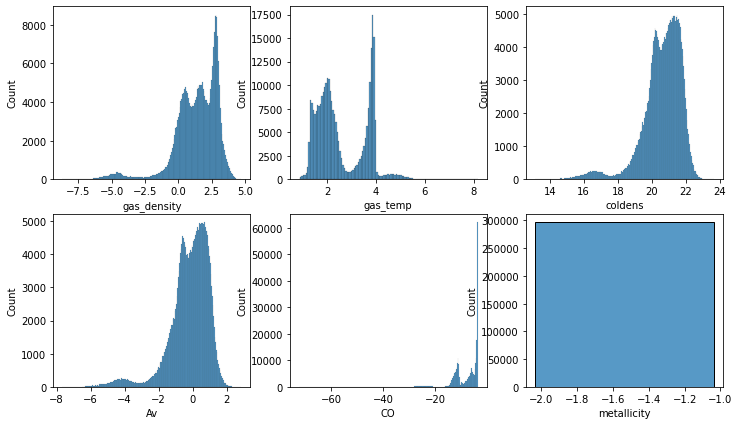

In [13]:
fig,axes=plt.subplots(2,3,figsize=(12,7))
axes=axes.flatten()

for i,variable in enumerate(["gas_density","gas_temp","coldens","Av","CO","metallicity"]):
    sns.histplot(np.log10(input_data[variable]),ax=axes[i])


In [14]:

input_data_test=pd.DataFrame()
input_data_test["C"]= f["PartType0"]["ChimesAbundances"][:,7]+f["PartType0"]["ChimesAbundances"][:,8]+f["PartType0"]["ChimesAbundances"][:,9]+f["PartType0"]["ChimesAbundances"][:,10]+f["PartType0"]["ChimesAbundances"][:,11]+f["PartType0"]["ChimesAbundances"][:,12]+f["PartType0"]["ChimesAbundances"][:,13]+f["PartType0"]["ChimesAbundances"][:,14]
input_data_test["E-"]= f["PartType0"]["ChimesAbundances"][:,0]
input_data_test["mu"]= f["PartType0"]["ChimesMu"][()]

Text(0.5, 0, 'C_test')

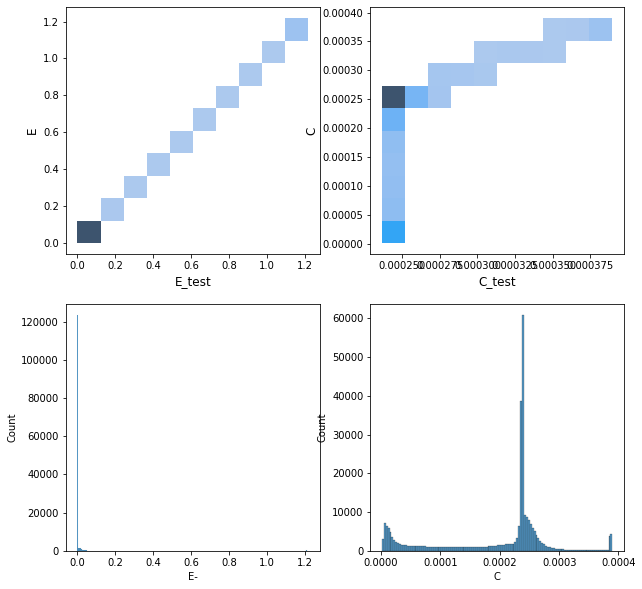

In [15]:
fig,axes=plt.subplots(2,2,figsize=(10,10))
axes=axes.flatten()
for i,variable in enumerate(["E-","C"]):
    g = sns.histplot(x=(input_data[variable]),y=(input_data_test[variable]), ax = axes[i],bins = 10)

sns.histplot((input_data["E-"]),ax=axes[2])
sns.histplot((input_data_test["C"]),ax=axes[3])
# axes[0].set(xlim=(-20,-5),ylim=(-20,-5)) 
axes[0].set_ylabel("E" , size = 12 )
axes[0].set_xlabel( "E_test" , size = 12)
# axes[1].set(xlim=(-10,3),ylim=(-10,3))
axes[1].set_ylabel("C" , size = 12 )
axes[1].set_xlabel( "C_test" , size = 12)



In [16]:
for species in emulator.autoencoder.species:
    if species not in input_data.columns:
        input_data[species]=0.0
input_data=input_data[emulator.physics_labels+list(emulator.autoencoder.species)]

In [17]:
input_data=emulator.prepare_inputs(input_data,learn_scaling=False)


/Users/raouf/Dropbox/Leiden Observatory/Chemulator/Gizmo_Chemulator/Notebooks/../src/chemulator.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data["metallicity"]=(input_data[self.species].values*self.c_idxs).sum(axis=1)
/Users/raouf/Dropbox/Leiden Observatory/Chemulator/Gizmo_Chemulator/Notebooks/../src/chemulator.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data["metallicity"]=input_data["metallicity"]/2.6e-4
/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-pac

In [18]:
input_data

,gas_temp,gas_density,local_radfield,zeta,metallicity,Chem_1,Chem_2,Chem_3,Chem_4,Chem_5,Chem_6,Chem_7,Chem_8
0,0.158587,0.353336,0.149923,0.5,0.892502,0.999083,0.408787,0.004807,0.000664,0.993641,0.000014,1.0,0.003847
1,0.223548,0.389080,0.000000,0.5,0.899653,0.999093,0.408785,0.004653,0.000670,0.993841,0.000002,1.0,0.004021
2,0.171339,0.385034,0.000000,0.5,0.894493,0.999100,0.408788,0.004795,0.000664,0.993692,0.000011,1.0,0.003818
3,0.125674,0.420124,0.000000,0.5,0.882059,0.999033,0.408785,0.004965,0.000661,0.993337,0.000046,1.0,0.003779
4,0.162630,0.379198,0.000000,0.5,0.891514,0.999073,0.408786,0.004809,0.000665,0.993616,0.000016,1.0,0.003871
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297043,0.900268,0.000000,0.481611,0.5,0.794076,0.936555,0.404014,0.016293,0.001200,0.117384,0.050033,1.0,0.031141
297044,0.904114,0.000000,0.481405,0.5,0.794938,0.940873,0.404312,0.015691,0.001186,0.174779,0.048350,1.0,0.030635
297045,0.905698,0.000000,0.483706,0.5,0.793189,0.941241,0.404340,0.015680,0.001184,0.180616,0.048157,1.0,0.030529
297046,0.897363,0.000000,0.486004,0.5,0.792170,0.945074,0.404609,0.015166,0.001170,0.239910,0.046485,1.0,0.029979


In [19]:
input_data["metallicity"][input_data["metallicity"] > 0]

0         0.892502
1         0.899653
2         0.894493
3         0.882059
4         0.891514
            ...   
297043    0.794076
297044    0.794938
297045    0.793189
297046    0.792170
297047    0.794482
Name: metallicity, Length: 297048, dtype: float64

# Make Predictions

Chemulator advances the chemistry by 1000 years each time it is called. So let's call it 1000 times to get the predictions for the next 1 Myr.

In [20]:
start=perf_counter()
nsteps=10
predict=emulator.predict_multiple_timesteps(input_data.copy(),nsteps)
end=perf_counter()
end=(end-start)/60.0
print(f"{nsteps} steps in {end} minutes")

/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10 steps in 3.1146688993 minutes


In [21]:
unscaled_predict=emulator.recover_real_values(predict)

/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [22]:
unscaled_predict

,gas_temp,dust_temp,H,H+,H2,H2+,H3+,HE,HE+,C+,...,H2O,H3O+,MG,MG+,CO+,CO,HCO+,O2,O2+,E-
0,68.330468,15.194149,0.208639,1.593586e-06,0.184697,5.385440e-12,2.813305e-10,0.109164,8.360121e-09,0.000030,...,7.087241e-10,4.469481e-11,1.563375e-08,0.000012,1.648550e-13,1.794590e-03,1.444529e-11,1.630939e-11,1.047969e-13,0.000044
1,81.822681,21.886142,0.132974,7.420364e-07,0.200349,2.550228e-12,2.409508e-10,0.109378,4.216558e-09,0.000015,...,4.112611e-10,3.644635e-11,7.080646e-09,0.000008,5.128333e-14,1.261672e-03,1.172891e-11,7.003175e-12,6.132071e-14,0.000023
2,77.011460,21.258059,0.167809,8.277808e-07,0.177064,2.474812e-12,1.704878e-10,0.109812,4.639840e-09,0.000018,...,3.355836e-10,2.795655e-11,8.993267e-09,0.000009,5.594641e-14,1.445668e-03,8.281917e-12,6.218927e-12,5.218876e-14,0.000028
3,64.877561,22.439114,0.247599,7.521073e-07,0.127911,1.491892e-12,5.762078e-11,0.110857,3.590073e-09,0.000022,...,1.804248e-10,1.276912e-11,1.501575e-08,0.000012,5.105590e-14,2.174371e-03,3.674102e-12,4.935669e-12,3.201869e-14,0.000034
4,76.241604,20.972930,0.166251,8.820936e-07,0.180548,2.742024e-12,1.899448e-10,0.109758,5.134530e-09,0.000018,...,3.486456e-10,2.937240e-11,8.804081e-09,0.000009,5.891029e-14,1.388006e-03,8.623323e-12,6.225923e-12,5.391060e-14,0.000028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297043,637.751235,12.271002,1.000000,1.400669e-04,0.006712,1.252994e-12,4.961161e-12,0.105835,2.935847e-07,0.000019,...,2.727389e-09,1.748314e-09,7.350579e-11,0.000004,4.000925e-12,1.296262e-07,1.356133e-10,1.821077e-12,2.990733e-10,0.000164
297044,635.932948,12.655947,1.000000,1.380231e-04,0.005158,1.116695e-12,3.380799e-12,0.106562,1.990004e-07,0.000018,...,1.273482e-09,9.968604e-10,5.937732e-11,0.000004,1.909980e-12,1.340653e-07,7.197055e-11,7.531420e-13,2.415574e-10,0.000160
297045,638.901518,12.918139,1.000000,1.305308e-04,0.004165,9.514875e-13,2.292265e-12,0.107438,1.510892e-07,0.000017,...,6.552891e-10,5.842744e-10,5.197101e-11,0.000005,1.048798e-12,1.099866e-07,4.184798e-11,3.977737e-13,1.896497e-10,0.000152
297046,639.880366,13.251451,1.000000,1.341487e-04,0.004224,1.029433e-12,2.536684e-12,0.107358,1.530733e-07,0.000017,...,6.374432e-10,6.208421e-10,4.829422e-11,0.000005,1.032591e-12,1.178338e-07,4.375267e-11,3.516774e-13,1.987388e-10,0.000155


In [23]:
snap = 60
filename_w = 'Chemulator_snap_%03d.hdf5' % snap
fw = h5py.File(filename_w, "w")
label = ["gas_temp","dust_temp","H","H+","H2","H2+","H3+","HE","HE+","C+","C","CH","CH+","CH2","CH2+","CH3+","CH3","CH4+","O+","CH4","O","CH5+","OH+","OH","H2O+","H2O","H3O+","MG","MG+","CO+","CO","HCO+","O2","O2+","E-"]

for i,variable in enumerate(label):
    fw.create_dataset(variable,data=unscaled_predict[variable],chunks = True)
#fw  = h5py.File("Pr_snap_60.hdf5", "r")

In [24]:
prediction  = h5py.File(filename_w, "r")

In [32]:
# prediction["CO"][()]

In [26]:
prediction.keys()

<KeysViewHDF5 ['C', 'C+', 'CH', 'CH+', 'CH2', 'CH2+', 'CH3', 'CH3+', 'CH4', 'CH4+', 'CH5+', 'CO', 'CO+', 'E-', 'H', 'H+', 'H2', 'H2+', 'H2O', 'H2O+', 'H3+', 'H3O+', 'HCO+', 'HE', 'HE+', 'MG', 'MG+', 'O', 'O+', 'O2', 'O2+', 'OH', 'OH+', 'dust_temp', 'gas_temp']>

In [31]:
# fig,axes=plt.subplots(2,2,figsize=(10,10))
# axes=axes.flatten()
# # for i,variable in enumerate(["gas_temp","dust_temp","CO","H2"]):
# #     sns.histplot(np.log10(prediction[variable][()]),ax=axes[i])
    
# for i,variable in enumerate(["gas_temp","CO","H2"]):
#     g = sns.histplot(x=np.log10(input_data[variable]),y=np.log10(prediction[variable][()]), ax = axes[i])
#     g.axes.axline((0,0), slope=1.0, c=".2", ls="--", zorder=0.)
    

In [30]:
filename = "./snapshot_060_eqm_1e6.hdf5"
f2 = h5py.File(filename, "r")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/raouf/Work_space/projects/ParticleGridMapper.jl/main_snap/CHIMES_1205_1e6/snapshot_060_eqm_1e6.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [34]:
f2.keys()

<KeysViewHDF5 ['EqmChemistryAbundances']>

In [35]:
#input_data_eqm=get_elemental_abundances(f2["EqmChemistryAbundances"])

In [36]:
input_data_eqm=pd.DataFrame()
# input_data_eqm

In [37]:
input_data_eqm["CO"]=f2["EqmChemistryAbundances"][:,148]
input_data_eqm["H2"]=f2["EqmChemistryAbundances"][:,137]

# input_data_eqm["CO_Chem"]=unscaled_predict["CO"]
# input_data_eqm["H2_Chem"]=unscaled_predict["H2"]

/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[(-10.0, 0.0), (0.0, 40000.0)]

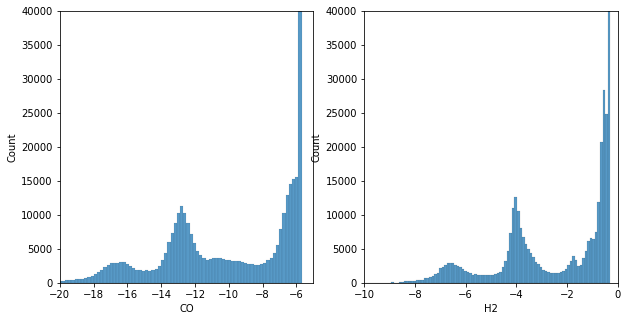

In [38]:
fig,axes=plt.subplots(1,2,figsize=(10,5))
axes=axes.flatten()
for i,variable in enumerate(["CO","H2"]):
    sns.histplot(np.log10(input_data_eqm[variable]),ax=axes[i])
axes[0].set(xlim=(-20,-5),ylim=(0,40000))
axes[1].set(xlim=(-10,0),ylim=(0,40000))
# axes[2].set(xlim=(-20,-5),ylim=(0,70000))
# axes[3].set(xlim=(-10,0),ylim=(0,70000))

/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'H2 (CHIMES)')

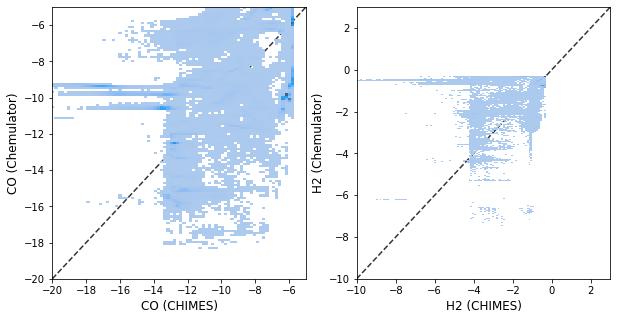

In [45]:
input_data["CO"]=f["PartType0"]["ChimesAbundances"][:,148]
input_data["H2"]=f["PartType0"]["ChimesAbundances"][:,137]

fig,axes=plt.subplots(1,2,figsize=(10,5))
axes=axes.flatten()
for i,variable in enumerate(["CO","H2"]):
    g = sns.histplot(x=np.log10(input_data_eqm[variable]),y=np.log10(prediction[variable][()]), ax = axes[i])
    g.axes.axline((-60,-60), slope=1.0, c=".2", ls="--", zorder=0.)

axes[0].set(xlim=(-20,-5),ylim=(-20,-5)) 
axes[0].set_ylabel("CO (Chemulator)" , size = 12 )
axes[0].set_xlabel( "CO (CHIMES)" , size = 12)
axes[1].set(xlim=(-10,3),ylim=(-10,3))
axes[1].set_ylabel("H2 (Chemulator)" , size = 12 )
axes[1].set_xlabel( "H2 (CHIMES)" , size = 12)

# savename = './plots/Prediction_CHIMES_snap_%03d.pdf' % snap
# plt.savefig(savename)


/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'H2 (CHIMES-EQM)')

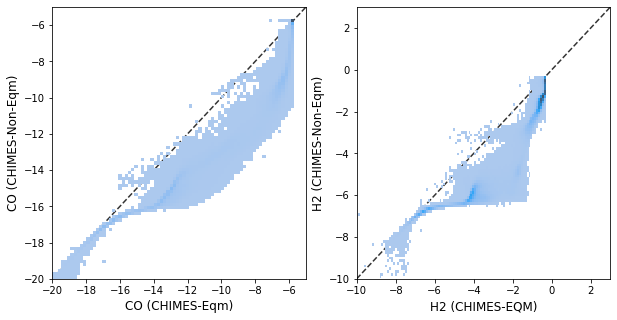

In [46]:
fig,axes=plt.subplots(1,2,figsize=(10,5))
axes=axes.flatten()
for i,variable in enumerate(["CO","H2"]):
    g = sns.histplot(x=np.log10(input_data_eqm[variable]),y=np.log10(input_data[variable]), ax = axes[i])
    g.axes.axline((-60,-60), slope=1.0, c=".2", ls="--", zorder=0.)

axes[0].set(xlim=(-20,-5),ylim=(-20,-5)) 
axes[0].set_ylabel("CO (CHIMES-Non-Eqm)" , size = 12 )
axes[0].set_xlabel( "CO (CHIMES-Eqm)" , size = 12)
axes[1].set(xlim=(-10,3),ylim=(-10,3))
axes[1].set_ylabel("H2 (CHIMES-Non-Eqm)" , size = 12 )
axes[1].set_xlabel( "H2 (CHIMES-EQM)" , size = 12)
